# Single Shot Detectors(SSD) for object detection

<img src="https://www.pyimagesearch.com/wp-content/uploads/2017/09/single_shot_detector_example.jpg">

When it comes to deep learning-based object detection there are three primary object detection methods that you’ll likely encounter:

- Faster R-CNNs (Girshick et al., 2015)
- You Only Look Once (YOLO) (Redmon and Farhadi, 2015)
- Single Shot Detectors (SSDs) (Liu et al., 2015)

Faster R-CNNs are likely the most “heard of” method for object detection using deep learning; however, the technique can be difficult to understand (especially for beginners in deep learning), hard to implement, and challenging to train.

Furthermore, even with the “faster” implementation R-CNNs (where the “R” stands for “Region Proposal”) the algorithm can be quite slow, on the order of 7 FPS.

If we are looking for pure speed then we tend to use YOLO as this algorithm is much faster, capable of processing 40-90 FPS on a Titan X GPU. The super fast variant of YOLO can even get up to 155 FPS.

The problem with YOLO is that it leaves much accuracy to be desired.

SSDs, originally developed by Google, are a balance between the two. The algorithm is more straightforward (and I would argue better explained in the original seminal paper) than Faster R-CNNs.

We can also enjoy a much faster FPS throughput than Girshick et al. at 22-46 FPS depending on which variant of the network we use. SSDs also tend to be more accurate than YOLO. To learn more about SSDs, please refer to Liu et al.


# MobileNetsL Efficient DNNs

<img src="https://www.pyimagesearch.com/wp-content/uploads/2017/09/mobilenet_depthwise.png">

_(Left) Standard convolutional layer with batch normalization and ReLU. (Right) Depthwise separable convolution with depthwise and pointwise layers followed by batch normalization and ReLU (figure and caption from Liu et al.)._


When building object detection networks we normally use an existing network architecture, such as VGG or ResNet, and then use it inside the object detection pipeline. The problem is that these network architectures can be very large in the order of 200-500MB.

Network architectures such as these are unsuitable for resource constrained devices due to their sheer size and resulting number of computations.

Instead, we can use MobileNets (Howard et al., 2017), another paper by Google researchers. We call these networks “MobileNets” because they are designed for resource constrained devices such as your smartphone. MobileNets differ from traditional CNNs through the usage of depthwise separable convolution (__Figure above__).

The general idea behind depthwise separable convolution is to split convolution into two stages:

1. A 3×3 depthwise convolution.
2. Followed by a 1×1 pointwise convolution.
This allows us to actually reduce the number of parameters in our network.

The problem is that we sacrifice accuracy — MobileNets are normally not as accurate as their larger big brothers…but they are much more resource efficient.

# Combining MobileNets and Single Shot Detectors for fast, efficient deep-learning based object detection

If we combine both the MobileNet architecture and the Single Shot Detector (SSD) framework, we arrive at a fast, efficient deep learning-based method to object detection.

The model we’ll be using in this blog post is a Caffe version of the [original TensorFlow](https://github.com/Zehaos/MobileNet) implementation by Howard et al. and was trained by chuanqi305 ([see GitHub](https://github.com/chuanqi305/MobileNet-SSD)).

The MobileNet SSD was first trained on the [COCO dataset](http://cocodataset.org/) (Common Objects in Context) and was then fine-tuned on PASCAL VOC reaching 72.7% mAP (mean average precision).

We can therefore detect 20 objects in images (+1 for the background class), including airplanes, bicycles, birds, boats, bottles, buses, cars, cats, chairs, cows, dining tables, dogs, horses, motorbikes, people, potted plants, sheep, sofas, trains, and tv monitors


# Deep learning-based object detection with OpenCV

Let's use the MobileNet SSD + deep neural network ( dnn ) module in OpenCV to build our object detector.


In [1]:
# import necessar packages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
# define paths to caffe models
path_caffemodel = "..//DNN_MODELS//MobileNetSSD_deploy.caffemodel"
path_model_architecture = "..//DNN_MODELS//MobileNetSSD_deploy.prototxt"


# define confidence probability t filter out weak detections
min_confidence = 0.2 # 20%

Let's initialize class labels and bounding box colors

In [47]:
# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

Now we need to load our model:

In [49]:
# load the serailized model
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(path_model_architecture, path_caffemodel)

[INFO] loading model...


Next, load the load an image and detect objects in it

In [77]:
# define path to image
path_image = "images/example_03.jpg" # change images here
image = cv2.imread(path_image)
h, w = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.0078,
                            (300,300), 127.5)

Pass this blob through the neural network:

In [78]:
# pass the blob through the network and obtain detections + predictions
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Now, we can loop over the detections nad classify them

[INFO] horse: 99.90%
[INFO] person: 55.43%
[INFO] pottedplant: 97.97%


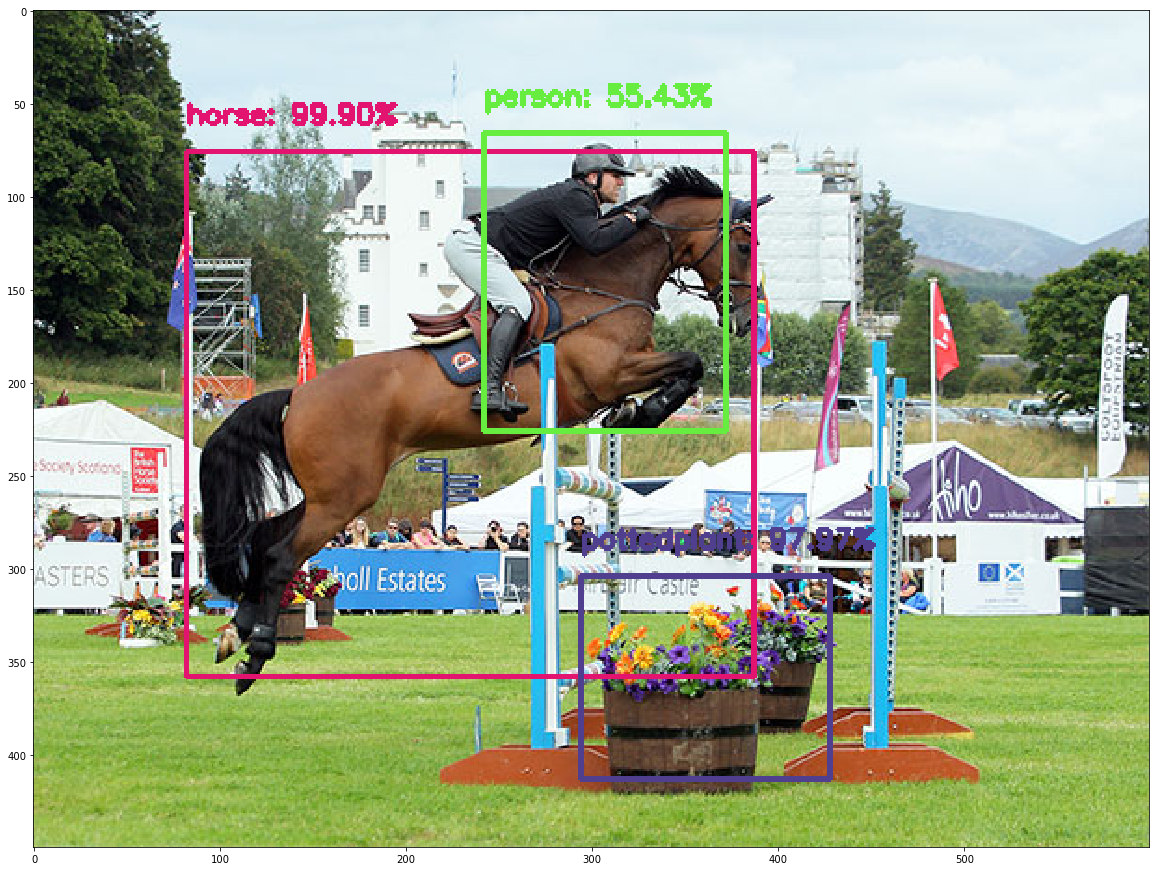

In [79]:
# loop ovet the detections 
for i in np.arange(0, detections.shape[2]):
    # extract the confidence (i.e. probability) associated with the 
    # prediction
    confidence = detections[0, 0, i, 2]
    
    # filter out weak detections 
    if confidence > min_confidence:
        # extract the index of the class label from detections,
        # then compute the (x, y)-coordinates of the bounding box for
        # the object
        idx = int(detections[0,0,i, 1])
        box = detections[0,0, i, 3:7] * np.array([w,h, w,h])
        (startX, startY, endX, endY) = box.astype("int")
        
        # display the prediction
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))
        cv2.rectangle(image, (startX, startY), (endX, endY), COLORS[idx], 2)
        y = startY-15 if startY-15 > 15 else startY + 15
        cv2.putText(image, label, (startX, y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)


        
# show the labeled image
plt.figure(figsize=(20,20))
plt.imshow(image[...,::-1])
plt.show()

In [ ]:
import